In [3]:
import gc
import os
import sys
import yaml
import glob
import numpy as np
import pickle
import tensorflow as tf
import random
import tqdm

from collections import defaultdict

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.datasets import delaunay
from spektral.layers import *
from spektral.utils.convolution import localpooling_filter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tqdm.contrib.concurrent import process_map, thread_map

%matplotlib inline

#tf.debugging.set_log_device_placement(True)

In [4]:
# Some helper functions
def yaml_load(filename: str) -> dict:
    with open(filename, 'rt') as f:
        return yaml.safe_load(f)

# Very bad way, but faster
def get_section(filename: str, section: str):
    lines = []
    with open(filename) as f:
        count = False

        for line in f.readlines():
            if line.startswith(section):
                count = True
                continue

            if count:
                if str.isspace(line[0]):
                    lines.append(line)
                else:
                    return lines
        return lines

# Preprocessing (optional)
## Generating Metadata

Here we are going to collect information about the CFGs and CDFGs of the applications and build a metadata database (at './data/ccpe-applications-information.yaml')to easily construct the inputs to GNN.
This information includes:
- Name of the applications
- Location of the file for an application and it respective optimization sequence
- Number of nodes in the graph representation of CFG and CDFG for each application
- The execution time for each application with each optimization sequence

This part is optional and must be run only once to create a metadata file.

*TODO*: Move this part to another notebook

First, lets list all CFG and CDFG files and discover how many nodes each graph has

In [ ]:
# Listing all CFG Files
cfg_directory = './data/ccpe-dados/cfg.llvm'
cfg_files = glob.glob(f'{cfg_directory}/**/*.yaml', recursive=True)
print(f"Found {len(cfg_files)} files in {cfg_directory}")

# Listing all CDFG Files
cdfg_directory = './data/ccpe-dados/cdfg.programl'
cdfg_files = glob.glob(f'{cdfg_directory}/**/*.yaml', recursive=True)
print(f"Found {len(cdfg_files)} files in {cdfg_directory}")

# Listing all runtime files
runtime_directory = './data/runtime'
runtime_files = glob.glob(f'{runtime_directory}/**/*.yaml', recursive=True)
print(f"Found {len(runtime_files)} files in {runtime_directory}")

# Get the number of nodes for each application in CFG representation
def get_number_of_cfg_nodes(filename):
    # Get lines for node section
    yaml_nodes_section = get_section(filename, 'nodes_features:')
    # Get the highest node number and return
    return (filename, max([int(node.split(':')[0]) for node in yaml_nodes_section])+1)

# Get the number of nodes for each application in CDFG representation
def get_number_of_cdfg_nodes(filename):
    # Get lines for nodes_features section
    yaml_node_features_section = get_section(filename, 'nodes_features:')
    # Get the highest node number and return
    return (filename, max([int(node.split(':')[0]) for node in yaml_node_features_section])+1)

# Get the number of nodes for all CFG graphs
cfg_number_of_nodes = thread_map(get_number_of_cfg_nodes, cfg_files, desc='CFG Files processed')
cfg_number_of_nodes = dict(cfg_number_of_nodes)
print(f"Number of CFG graphs: {len(cfg_number_of_nodes)}")

# Get the number of nodes for all CDFG graphs
cdfg_number_of_nodes = thread_map(get_number_of_cdfg_nodes, cdfg_files, desc='CDFG Files processed')
cdfg_number_of_nodes = dict(cdfg_number_of_nodes)
print(f"Number of CDFG graphs: {len(cdfg_number_of_nodes)}")


In [ ]:
values = [int(v) for v in cfg_number_of_nodes.values()]
print(f"""CFG Graphs. Statistics from {len(values)} applications:
    Min value: {min(values)}
    Max value: {max(values)}
    Average: {np.average(values)}
    Stdev: {np.std(values)}
    Mean: {np.mean(values)}
    25th percentile: {np.percentile(values, 25)}
    Median: {np.median(values)}
    75th percentile: {np.percentile(values, 75)}
    95th percentile: {np.percentile(values, 95)}""")

plt.hist(values, 20)


In [ ]:
values = [int(v) for v in cdfg_number_of_nodes.values()]
print(f"""CDFG Graphs. Statistics from {len(values)} applications:
    Min value: {min(values)}
    Max value: {max(values)}
    Average: {np.average(values)}
    Stdev: {np.std(values)}
    Mean: {np.mean(values)}
    25th percentile: {np.percentile(values, 25)}
    Median: {np.median(values)}
    75th percentile: {np.percentile(values, 75)}
    95th percentile: {np.percentile(values, 95)}""")

plt.hist(values, 20)


Now we are going to group all CFGs and CFGs files by its applications and optimization sequences
We going to have a dictionary, like this example:

{

    application_1: {

        sequence_0: {

            cfg_file: '/path/to/cfg/file'

            number_cfg_nodes: 10

            cdfg_file: '/path/to/cdfg/file'

            number_cdfg_nodes: 20

            exectime: 1.234

        }

        sequence_1: {
            
            cfg_file: '/path/to/cfg/file'

            number_cfg_nodes: 15

            cdfg_file: '/path/to/cdfg/file'

            number_cdfg_nodes: 22

            exectime: 0.987

        }

    }

    application_2: {...}
    
 }

This information is used to generate inputs to GNN and is saved to './data/ccpe-applications-information.yaml'

In [ ]:
# The output file to store processed information
output_file = './data/ccpe-applications-information.yaml'

def get_representation(filename: str) -> dict:
    representation = defaultdict(dict)
    # Extract the application name, without path and extensions
    app_name = os.path.basename(filename)
    app_name = app_name.split('.rnd.yaml')[0]
    
    # Lets group all CFG and CDFG files with same prefix (i.e., CFGs and CDFGs for the same application)
    cfgs_with_prefix = [fname for fname in cfg_files if os.path.basename(fname).startswith(app_name)]
    cdfgs_with_prefix = [fname for fname in cdfg_files if os.path.basename(fname).startswith(app_name)]

    # Get the rutime information for the application. It includes the execution time for the application
    # compiled with different optimization sequences
    with open(filename, 'rt') as f:
        app_runtime_info = yaml.safe_load(f)

    # Group CFGs and CDFGs filenames by their optimization sequences 
    # E.g.: CFGs={0: file1, 1: file2, ..., 99: file99}
    cfgs_with_prefix = {int(os.path.basename(fname).split('.ll.')[0].split('.')[-1]): fname for fname in cfgs_with_prefix}
    cdfgs_with_prefix = {int(os.path.basename(fname).split('.progaml.')[0].split('.')[-1]): fname for fname in cdfgs_with_prefix}

    # Finally, let's group applications with sequence levels and runtime info
    # E.g: representation_files = {app1: {0: (CFG_FILE, CDFG_FILE, EXECTIME), 1: (CFG_FILE, CDFG_FILE, EXECTIME), ..., }, app2: {...} }
    for sequence_no, values in app_runtime_info.items():
        if sequence_no not in cfgs_with_prefix:
            print(f"CFG from application {app_name} with optimization sequence {sequence_no} does not exists. Skipping..")
            continue
        if sequence_no not in cdfgs_with_prefix:
            print(f"CDFG from application {app_name} with optimization sequence {sequence_no} does not exists. Skipping..")
            continue
        representation[app_name][sequence_no] = {
            'cfg_file': cfgs_with_prefix[sequence_no], 
            'number_cfg_nodes': cfg_number_of_nodes[cfgs_with_prefix[sequence_no]],
            'cdfg_file': cdfgs_with_prefix[sequence_no],
            'number_cdfg_nodes': cdfg_number_of_nodes[cdfgs_with_prefix[sequence_no]],
            'exectime': app_runtime_info[sequence_no]['f'],
            'runtime_file': filename
        }
    
    return representation

# Iterate over each runtime file (applications that effectively executed)
representation_files = thread_map(get_representation, runtime_files, desc="Applications processed")
# Merge all dicts to a single dict
representation_files = {k: v for d in representation_files for k, v in d.items()}

print(f'Processed {len(representation_files)} applications...')

with open(output_file, 'wt') as f:
    yaml.dump(representation_files, f)
    print(f"Information from {len(representation_files)} applications were successfully saved to {output_file}")

# Training CFG Input Generation (Optional)

First lets filter graphs whose number of nodes is below a determined shape (indicated by network_input_graph_shape). Larger graphs will be removed.

In [3]:
# Defining some useful variables
metadata_file = './data/ccpe-applications-information.yaml'
network_input_graph_shape = (150, 150)
network_input_features_shape = (150, 67)

metadata_info = yaml_load(metadata_file)

# Lets filter CFG files whose number of nodes is less than network_input_graph_shape
# For example, only CFG graphs with less than 150 nodes. Note: the graphs are represented as adjacency matrix (a quadratic matrix)
filtered_graph_files = {
    benchmark_name: {
        opt_seq: opt_values 
        for opt_seq, opt_values in values.items() if opt_values['number_cfg_nodes'] < network_input_graph_shape[0]
    } for benchmark_name, values in metadata_info.items()
}

# Remove applications that has less than 2 graphs with less than network_input_graph_shape
filtered_graph_files = {benchmark_name: values for benchmark_name, values in filtered_graph_files.items() if len(values) > 2}
print(f"Number of graphs with adjacency matrix below shape {network_input_graph_shape}: {sum([len(values) for _, values in filtered_graph_files.items()])}")


Number of graphs with adjacency matrix below shape (150, 150): 17137


And now, we are going to sample graphs (indicated by 'no_samples') from the filtered_graphs (i.e. below a determined shape). 

To do this we randomly select 'no_samples' applications and then, for each application, we select 2 different graphs (with different optimization sequences). At end, we will have a list of tuples with the following format: \[(CFGFILE1, CFGFILE2, SPEEDUP), ...\].

*Note*: The graphs are not loaded yet, only the file names are selected.

In [4]:
no_samples = 10000  # 2 graphs for each sample...
samples = []

# Lets choose 'no_samples' random CFG applications and then choose 2 different graphs from each application.
# Note: graphs here are the files (the graphs is not loaded yet).
# We will have a list of tuples: [(CFGFILE1, CFGFILE2, SPEEDUP), ...]
for s in random.choices(list(filtered_graph_files.keys()), k=no_samples):
    opt_seq1, opt_seq2 = random.sample(list(filtered_graph_files[s].keys()), 2)
    t = (
        filtered_graph_files[s][opt_seq1]['cfg_file'], 
        filtered_graph_files[s][opt_seq2]['cfg_file'],
        filtered_graph_files[s][opt_seq1]['exectime']/filtered_graph_files[s][opt_seq2]['exectime']
    )
    samples.append(t)

print(f"Sampled {len(samples)} CFGs")
print(f"First sample of {len(samples)} samples (example of output): {samples[0]}")


Sampled 10000 CFGs
First sample of 10000 samples (example of output): ('./data/ccpe-dados/cfg.llvm/extracted/PolyBench.linear-algebra-blas-syr2k.0.61.ll.cfg.yaml', './data/ccpe-dados/cfg.llvm/extracted/PolyBench.linear-algebra-blas-syr2k.0.19.ll.cfg.yaml', 1.4383629465581889)


Now we are going to load the selected graphs and create a np.array as input to our GNN

In [15]:
# Load the graph and features from file
def load_graph_from_file(filename: str, network_shape: tuple, features_shape: tuple) -> tuple:
    x = yaml_load(filename)
    
    # The graph is a list of adjacency. Lets transform it to an adjacency matrix
    graph = np.full(network_shape, False)
    for node, nodes_list in x['nodes'].items():
        for n in nodes_list:
            if node >= network_shape[0] or n >= network_shape[0]:
                print(f'WARNING. GRAPH {filename}: node={node}, n={n}, network_shape={network_shape}. Skipping')
                return (None, None)
            graph[node][n] = True

    # Lets read the features from the graphs
    features = np.zeros(features_shape)
    for node, node_list in x['nodes_features'].items():
        if node >= features_shape[0]:
            print(f'WARNING. FEATURE {filename}: node={node}, features_shape={features_shape}. Skipping')
            return (None, None)
        features[node] = node_list

    return graph, features

def load_sample(sample_tuple: tuple) -> tuple:
    graph1, features1 = load_graph_from_file(sample_tuple[0], network_input_graph_shape, network_input_features_shape)
    graph2, features2 = load_graph_from_file(sample_tuple[1], network_input_graph_shape, network_input_features_shape)

    if graph1 is None or graph2 is None:
        return None
    
    graphs = np.empty((2, network_input_graph_shape[0], network_input_graph_shape[1]))
    graphs[0] = graph1
    graphs[1] = graph2

    features = np.empty((2, network_input_features_shape[0], network_input_features_shape[1]))
    features[0] = features1
    features[1] = features2

    # Returns:
    # A matrix with 2 graphs with shape: (2, network_input_graph_shape[0], network_input_graph_shape[1])
    # A matrix with 2 features with shape: (2, network_input_features_shape[0], network_input_features_shape[1])
    # A float with speedup of CFG1/CFG2
    return graphs, features, np.array([sample_tuple[2]])

# This function return a list of tuples, where each tuple is composed by:
# np.array with 2 graphs, np.array with 2 features, speedup
input_samples = thread_map(load_sample, samples, desc='Number of graphs/features loaded')
# Remove errors
input_samples = [i for i in input_samples if i is not None]

print(f"Number of samples effectively loaded: {len(input_samples)}")


Number of graphs/features loaded:   0%|          | 0/10000 [00:00<?, ?it/s]

WARNING. GRAPH ./data/ccpe-dados/cfg.llvm/extracted/Olden.voronoi.0.76.ll.cfg.yaml: node=130, n=153, network_shape=(150, 150). Skipping
WARNING. GRAPH ./data/ccpe-dados/cfg.llvm/extracted/CAPBenchmarks.RT.0.2.ll.cfg.yaml: node=65, n=150, network_shape=(150, 150). Skipping
WARNING. GRAPH ./data/ccpe-dados/cfg.llvm/extracted/Olden.voronoi.0.30.ll.cfg.yaml: node=130, n=153, network_shape=(150, 150). Skipping
WARNING. GRAPH ./data/ccpe-dados/cfg.llvm/extracted/Olden.voronoi.0.91.ll.cfg.yaml: node=126, n=150, network_shape=(150, 150). Skipping
WARNING. GRAPH ./data/ccpe-dados/cfg.llvm/extracted/Olden.voronoi.0.37.ll.cfg.yaml: node=132, n=153, network_shape=(150, 150). Skipping
WARNING. GRAPH ./data/ccpe-dados/cfg.llvm/extracted/Olden.voronoi.0.76.ll.cfg.yaml: node=130, n=153, network_shape=(150, 150). Skipping
WARNING. GRAPH ./data/ccpe-dados/cfg.llvm/extracted/CAPBenchmarks.RT.0.2.ll.cfg.yaml: node=65, n=150, network_shape=(150, 150). Skipping
WARNING. GRAPH ./data/ccpe-dados/cfg.llvm/extr

Finally, we are going to concatenate all matrices of CFGs in a single CFG matrix, all matrices of features in a single feature matrices and all speedups in a speedup matrix. This representation is the input to our GNN

In [22]:
# Finally, transforming the list of graphs in a big np.array with shape: (no_samples, 2, network_input_graph_shape[0], network_input_graph_shape[1])
input_graphs = np.stack([i[0] for i in input_samples], axis=0)
print(f"Input graphs shape: {input_graphs.shape}")
input_features = np.stack([i[1] for i in input_samples], axis=0)
print(f"Input features shape: {input_features.shape}")
speedups = np.stack([i[2] for i in input_samples], axis=0)
print(f"Input speedups (target) shape: {speedups.shape}")

In [2]:
# Save to numpy pickle
output_file = './data/graphs_and_features'
np.savez_compressed(output_file, graphs=input_graphs, features=input_features, speedups=speedups)
print(f"Graphs, features and targets were saved (compressed) to {output_file}.npz")

NameError: name 'np' is not defined

# Training with CFG representation

In [7]:
# Read data
input_data = './data/graphs_and_features.npz'
with np.load(input_data, allow_pickle=True) as all_data:
    A = all_data['graphs']
    X = all_data['features']
    y = all_data['speedup']

print('Data loaded!')

# Generate classed based on speedup
y_c = np.zeros(shape=(y.shape[0],5))

for i in range(0, y.shape[0]):
    if y[i] <= 0.996:
        y_c[i,0]=1
    elif y[i] > 0.996 and y[i] < 1.0:
        y_c[i,1]=1
    elif (y[i] >= 1.0 and y[i] < 1.15):
        y_c[i,2]=1
    elif (y[i] > 1.15):
        y_c[i,3]= 1
    y_c[i,4] = y[i]
y = y_c

# Remove 0 columns in nodes features
#idx = np.argwhere(np.all(X[..., :] == 0, axis=(0,1,2)))
#X = np.delete(X, idx, axis=3)

print(f"""Datas:
A shape (graphs): {A.shape}
X shape (features): {X.shape}
y shape (targets): {y.shape} 
""")


Data loaded!
Datas:
A shape (graphs): (9953, 2, 150, 150)
X shape (features): (9953, 2, 150, 67)
y shape (targets): (9953, 5) 



In [8]:
# Preprocess graphs with Spektral
A[:,0,:,:] = GraphConv.preprocess(A[:,0,:,:]).astype('f4')
A[:,1,:,:] = GraphConv.preprocess(A[:,1,:,:]).astype('f4')

# Split Train and test sets
A_train, A_test, x_train, x_test, y_train, y_test = train_test_split(A, X, y, test_size=0.1)

# Cleanup
gc.collect()

1521

In [9]:
# Defining some parameters for training
N = X.shape[-2]                 # Number of nodes in the graphs
F = X.shape[-1]                 # Original feature dimensionality
n_classes = y_c.shape[-1]-1     # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

In [10]:
# Model definition
conv   = GraphConv(45,activation='relu',use_bias=False)
mincut = MinCutPool(N // 2)
conv2  = GraphConv(55,activation='relu',use_bias=False)
pool   = GlobalAttnSumPool()

# First Graph Layers
X1_in = Input(shape=(N, F))
A1_in = Input((N, N))
gc2_1 = conv([X1_in, A1_in])
gc2_1, A1 = mincut([gc2_1,A1_in])
gc2_1 = conv2([gc2_1, A1])
pool_1 =  pool(gc2_1)
d1 = Dense(200,activation='relu')(pool_1)

# Second Graph Layers
X2_in = Input(shape=(N, F))
A2_in = Input((N, N))
gc2_2 = conv([X2_in, A2_in]) # Notice that both graphs shares layers (shared weights)
gc2_2, A2 = mincut([gc2_2,A2_in])
gc2_2 = conv2([gc2_2, A2])
pool_2 = pool(gc2_2)
d2 = Dense(200,activation='relu')(pool_2)

# Dense final layers
merged = Concatenate()([d1, d2])

merged1 = Dense(800,activation='relu')(merged)
merged2 = Dense(32,activation='relu')(merged1)

classe = Dense(n_classes, name="class",activation="softmax")(merged2)
speedup = Dense(1, name="speddup")(merged2)

# Build model
model = Model(inputs=[X1_in, A1_in,X2_in, A2_in], outputs=[classe,speedup])
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=['categorical_crossentropy', 'mse'],loss_weights=[1, 0.00005], weighted_metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 67)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 67)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 150, 150)]   0                                            
______________________________________________________________________________________________

532/532 [==============================] - 3s 6ms/step - loss: 2.4797 - class_loss: 0.6195 - speddup_loss: 28920.2099 - class_acc: 0.7429 - speddup_acc: 0.0000e+00 - val_loss: 8.6716 - val_class_loss: 1.0161 - val_speddup_loss: 144622.4062 - val_class_acc: 0.6049 - val_speddup_acc: 0.0000e+00
Epoch 437/500
532/532 [==============================] - 3s 6ms/step - loss: 2.0580 - class_loss: 0.6276 - speddup_loss: 20333.6890 - class_acc: 0.7430 - speddup_acc: 0.0000e+00 - val_loss: 8.7157 - val_class_loss: 1.0612 - val_speddup_loss: 144608.9844 - val_class_acc: 0.6228 - val_speddup_acc: 0.0000e+00
Epoch 438/500
532/532 [==============================] - 3s 6ms/step - loss: 1.7661 - class_loss: 0.6268 - speddup_loss: 14523.4810 - class_acc: 0.7357 - speddup_acc: 0.0000e+00 - val_loss: 8.7141 - val_class_loss: 1.0596 - val_speddup_loss: 144631.3125 - val_class_acc: 0.6138 - val_speddup_acc: 0.0000e+00
Epoch 439/500
532/532 [==============================] - 3s 6ms/step - loss: 2.4618 - clas

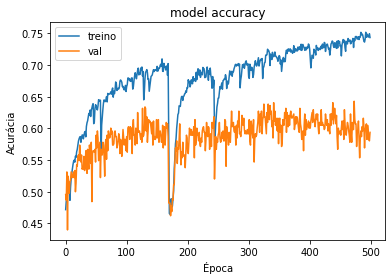

In [11]:
# Train model
fltr1 = A_train[:,0,:,:]
fltr2 = A_train[:,1,:,:]

history = model.fit([x_train[:,0,:,:],fltr1, x_train[:,1,:,:], fltr2],
        [y_train[:,0:4],y_train[:,4]],
          batch_size=batch_size,
          validation_split=0.05,
          epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
plt.savefig("test.pdf")

In [12]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]],
        [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

Evaluating model.
63/63 [==============================] - 1s 4ms/step - loss: 6.8422 - class_loss: 1.5375 - speddup_loss: 97659.1641 - class_acc: 0.6024 - speddup_acc: 0.0000e+00
Done. Test loss: 6.8422. Test acc: 1.54


In [13]:
print("Confusion matrix:")
y_pred = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
y_pred = np.argmax(y_pred[0], axis=-1)
y_test = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(y_test,y_pred)
print(cm)

Confusion matrix:
[[347   2  95  24]
 [ 18   3  13   2]
 [111   4 142  32]
 [ 61   1  33 108]]
